# P2 Mean Analysis at 10s
## 150-200 ms

## Load necessary libraries
If any of these don't load, you'll need to install them. Assuming you installed Jupyter through Anaconda, you would do the following to install a package
`conda install -c r r-[pkgName]`
e.g., to install ggplot2 you would do:
`conda install -c r r-ggplot2`

In [1]:
R.home()

[1] "/opt/conda/lib/R"

In [2]:
library(ggplot2)
library(mgcv)
library(parallel)
library(plyr)
library(tidyr)
library(data.table)
library(viridis)
# library(ggthemes)
library(nlme)

Loading required package: nlme
This is mgcv 1.8-29. For overview type 'help("mgcv-package")'.
Loading required package: viridisLite


## Set parameters for this analysis

In [3]:
CurTimeWin = '150-200'
component = 'P2_mean'

topdir = getwd()
expt = 'eLearn'
outdir = (paste(topdir,'/R-data/Stats_Output',sep=''))
dir.create(outdir, showWarnings = FALSE)
# Functions we'll use later
source(paste(topdir,'/NCIL_functions.R',sep=""))

# source(paste(topdir,'/romr.fnc.R',sep=""))


# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores = 4

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

In [4]:
subjects = c('01','02','03','04','05','06','07','08','09','10','11','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','37','38','39','40','41','42','43','44','45','48','49','50','51','52')

## Load Data

In [5]:
dat  <- {}
for(s in 1:length(subjects)) {
    infile <- paste(topdir, '/R-data/', subjects[s], '_', component, '_', CurTimeWin, '.csv',sep="")
    print(infile)
    tmpdat <- read.csv(infile) 
    tmpdat$Subj <- as.factor(subjects[s])
    tmplong <- gather(tmpdat, channel, meanAmpl, Fp1:VEOG) 
    tmplong$channel = as.factor(tmplong$channel)
    dat  <- rbind(dat, tmplong)
    }

setwd(topdir)

[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/01_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/02_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/03_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/04_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/05_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/06_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/07_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/08_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/09_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analysis/R-data/10_P2_mean_150-200.csv"
[1] "/media/NCILscience/ColinConrad_eLearn/full_study/analys

In [6]:
colnames(dat)[1] <- 'epoch'
colnames(dat)[2] <- 'condition'

In [7]:
head(dat) # displaying first 6? list continues for each subject, each channel and each epoch?

epoch,condition,Subj,channel,meanAmpl
<int>,<fct>,<fct>,<fct>,<dbl>
0,Beep_Start,01,Fp1,23.2806
1,Unlabelled/Standard,01,Fp1,15.6645
2,Unlabelled/Standard,01,Fp1,12.7433
3,Unlabelled/Standard,01,Fp1,-18.3629
4,Unlabelled/Standard,01,Fp1,-2.9732
5,Unlabelled/Standard,01,Fp1,-5.2915


In [8]:
summary(dat)

     epoch                    condition            Subj        
 Min.   :   0   Unlabelled/Standard:4270230   11     : 115124  
 1st Qu.: 826   Unlabelled/Oddball : 843608   18     : 114512  
 Median :1653   MW2/Standard       :  65994   48     : 114512  
 Mean   :1654   MW1/Standard       :  50048   03     : 114478  
 3rd Qu.:2480   MW3/Standard       :  48722   21     : 114444  
 Max.   :3385   MW4/Standard       :  35394   38     : 114444  
                (Other)            :  83266   (Other):4709748  
    channel           meanAmpl      
 C3     : 158743   Min.   :-925.82  
 C4     : 158743   1st Qu.:  -4.22  
 C5     : 158743   Median :   0.12  
 C6     : 158743   Mean   :   0.17  
 CP3    : 158743   3rd Qu.:   4.55  
 CP4    : 158743   Max.   : 932.98  
 (Other):4444804                    

### Assign ROI labels to electrodes we will analyze, then drop remaining electrodes

Let's not use these in the initial analysis. We should keep the working code here just in case.

In [9]:
dat$ROI = 'NA' # which electrodes WILL we analyze? Should I focus just on the Pz/POz region?

dat$ROI<-rep('0',times=nrow(dat))

occipital = c('POz', 'PO7', 'PO8', 'Oz', 'O1', 'O2')

parietal = c('Pz', 'P3', 'P4', 'CPz', 'CP3', 'CP4')

frontal = c('Fz', 'Cz', 'C3', 'C4', 'F3', 'F4')

which(dat$channel%in%occipital)->x
dat$ROI[x]<-"Occipital" 

which(dat$channel%in%parietal)->x
dat$ROI[x]<-"Parietal" 

which(dat$channel%in%frontal)->x
dat$ROI[x]<-"Frontal" 

dat$ROI <- factor(dat$ROI, levels = c("Occipital", "Parietal", 'Frontal'))

# dat = droplevels(dat)
dat <- dat %>% drop_na(ROI)

In [10]:
dat <- dat[ which(dat$condition!='Beep_Start' & 
                  dat$condition!='Experience_Sample' & 
                  dat$condition!='Unlabelled/Standard' & 
                  dat$condition!='Unlabelled/Oddball'),]

In [11]:
dat <- dat %>%  separate(condition, c("MentalState", "StimType"), "/")

In [12]:
dat$StimType <- as.factor(dat$StimType)

which(dat$MentalState%in%'MW1') -> x
dat$MentalState[x] <- 'MW1'
which(dat$MentalState%in%'MW2') -> x
dat$MentalState[x] <- 'MW2'
which(dat$MentalState%in%'MW3') -> x
dat$MentalState[x] <- 'MW3'
which(dat$MentalState%in%'MW4') -> x
dat$MentalState[x] <- 'MW4'
which(dat$MentalState%in%'MW5') -> x
dat$MentalState[x] <- 'MW5'
dat$MentalState <- as.factor(dat$MentalState)

In [13]:
summary(dat)

     epoch      MentalState     StimType           Subj           channel     
 Min.   : 171   MW1:31500   Oddball : 21582   03     :  2880   C3     : 7448  
 1st Qu.: 493   MW2:41634   Standard:112482   15     :  2880   C4     : 7448  
 Median :1943   MW3:30672                     39     :  2880   CP3    : 7448  
 Mean   :1685   MW4:22446                     01     :  2862   CP4    : 7448  
 3rd Qu.:2615   MW5: 7812                     20     :  2862   CPz    : 7448  
 Max.   :3384                                 23     :  2862   Cz     : 7448  
                                              (Other):116838   (Other):89376  
    meanAmpl              ROI       
 Min.   :-69.394   Occipital:44688  
 1st Qu.: -4.760   Parietal :44688  
 Median :  0.033   Frontal  :44688  
 Mean   :  0.148                    
 3rd Qu.:  4.999                    
 Max.   : 98.378                    
                                    

## Create Random Effects Variables

Create variable coding the condition x Subj random effects. This serves to address any heteroscedasticity (unequal variance) across conditions, and remove uninteresting, subject-specific noise.

In [14]:
dat$electrodebySubj = as.factor(paste(as.character(dat$Subj)
                                , as.character(dat$channel),
                                 sep = "_"))


In [15]:
dat$StimTypebySubj = as.factor(paste(as.character(dat$Subj)
                                , as.character(dat$StimType),
                                 sep = "_"))

In [16]:
dat$MentalStatebySubj = as.factor(paste(as.character(dat$Subj)
                                , as.character(dat$MentalState),
                                 sep = "_"))

In [17]:
summary(dat)

     epoch      MentalState     StimType           Subj           channel     
 Min.   : 171   MW1:31500   Oddball : 21582   03     :  2880   C3     : 7448  
 1st Qu.: 493   MW2:41634   Standard:112482   15     :  2880   C4     : 7448  
 Median :1943   MW3:30672                     39     :  2880   CP3    : 7448  
 Mean   :1685   MW4:22446                     01     :  2862   CP4    : 7448  
 3rd Qu.:2615   MW5: 7812                     20     :  2862   CPz    : 7448  
 Max.   :3384                                 23     :  2862   Cz     : 7448  
                                              (Other):116838   (Other):89376  
    meanAmpl              ROI        electrodebySubj      StimTypebySubj  
 Min.   :-69.394   Occipital:44688   03_C3  :   160   20_Standard:  2520  
 1st Qu.: -4.760   Parietal :44688   03_C4  :   160   48_Standard:  2502  
 Median :  0.033   Frontal  :44688   03_CP3 :   160   01_Standard:  2484  
 Mean   :  0.148                     03_CP4 :   160   02_Standard:  

## Run initial full model to identify and remove outliers

Now run the model

In [18]:
m0 <- bam(meanAmpl ~ StimType * MentalState 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

In [19]:
dat <- romr.fnc(m0, dat, trim=2.5)$data

m1 <- bam(meanAmpl ~ StimType * MentalState 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

n.removed = 3134 
percent.removed = 2.3377 


#### Find and remove outliers, then update model


Method: fREML   Optimizer: perf newton
full convergence after 7 iterations.
Gradient range [-0.0014309,-0.000000032894]
(score 476555 & scale 71.545).
Hessian positive definite, eigenvalue range [20.993,67027].
Model rank =  58 / 58 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

          k'  edf k-index p-value
s(Subj) 48.0 44.4      NA      NA


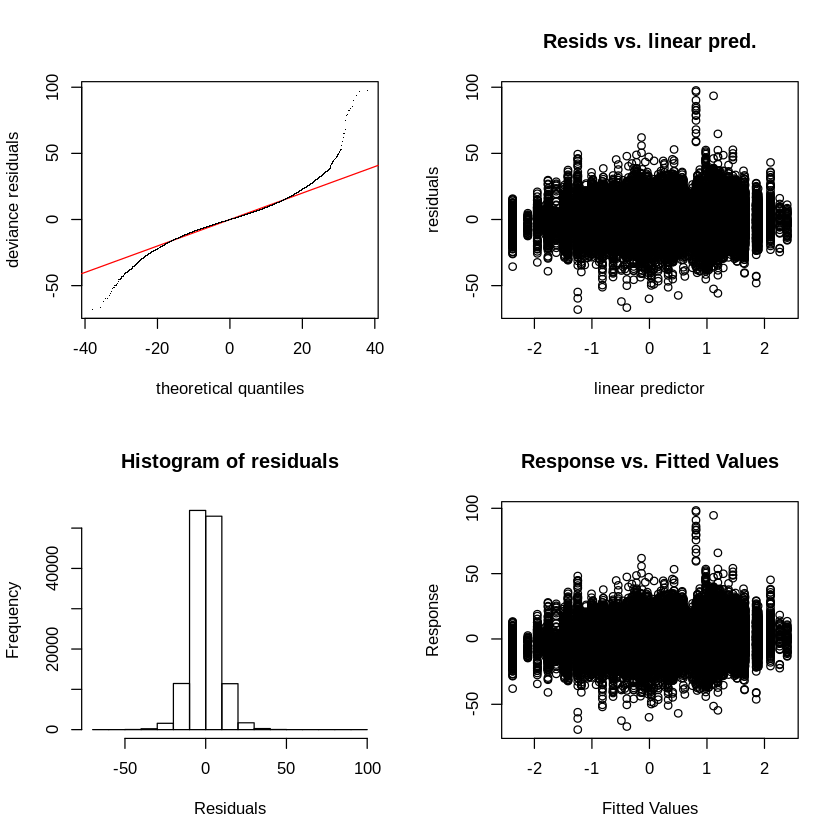

In [20]:
gam.check(m0)

In [ ]:
gam.check(m1)


Method: fREML   Optimizer: perf newton
full convergence after 7 iterations.
Gradient range [-0.000060501,-0.000000001223]
(score 448210 & scale 55.005).
Hessian positive definite, eigenvalue range [21.296,65460].
Model rank =  58 / 58 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

          k'  edf k-index p-value
s(Subj) 48.0 44.8      NA      NA


In [ ]:
summary(dat)

## Compute cell means and CIs, and plot for occipital region

In [22]:
bdat <- dat

In [23]:
dat <- subset(bdat, ROI == 'Frontal')

trialAvg = ddply(dat, 
                 .(Subj, MentalState, StimType),
                 summarize, 
                 Ampl = round(mean(meanAmpl), 3))


sumstats <- summarySEwithin(trialAvg, 
                            measurevar = "Ampl", 
                            withinvars = c("MentalState", "StimType"),
                            idvar = "Subj")

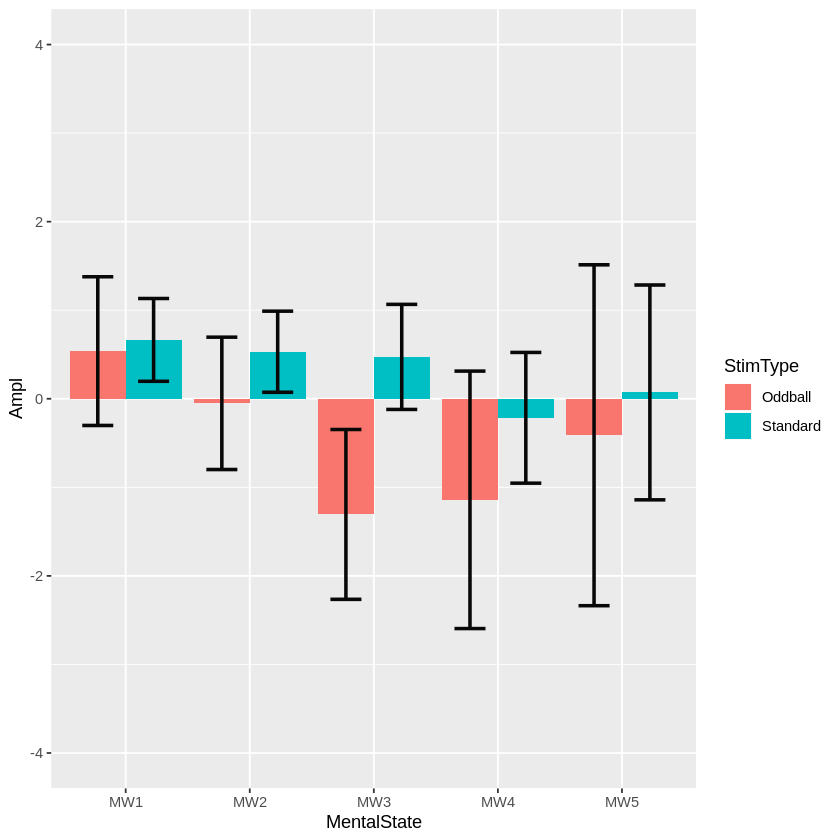

In [24]:
ggplot(sumstats, aes(y=Ampl, x=MentalState, fill=StimType)) + 
        geom_bar(position='dodge', stat='identity' ) +
        geom_errorbar(aes(ymin = Ampl - ci, ymax = Ampl + ci), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-4,4)

#ggsave(filename='2020-experiment-2-p2.png', dpi=600)

# GAMM analysis
### Compute the family of models we will consider, first contrasting random effects structures

In [25]:
cl <- makeCluster(num_cores)

m0 <- bam(meanAmpl ~ StimType * MentalState 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m1f <- bam(meanAmpl ~ StimType  
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m2f <- bam(meanAmpl ~ MentalState 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [26]:
AICtab = as.data.frame(AIC(m0,m1f,m2f))
minAIC =  min(AIC(m0,m1f,m2f)[2]) 

AICtab$deltaAIC = lapply(AICtab$AIC, deltaAICfunc)
AICtab$deltaAIC = as.numeric(AICtab$deltaAIC)

AICtab$L= lapply(AICtab$deltaAIC, f)
AICtab$L = as.numeric(AICtab$L)

sumlike = sum(AICtab$L)

AICtab$wAIC = lapply(AICtab$L, wAICfunc)
AICtab$wAIC = as.numeric(AICtab$wAIC)

# compute relative likelihood of each model relative to model with smallest AIC/max wAIC
# So, xBetter is interpreted as "the best model is x times more likely than this model"
wAICmax = max(AICtab$wAIC)
AICtab$xBetter = lapply(AICtab$wAIC, xBetterfunc)
AICtab$xBetter = as.numeric(AICtab$xBetter)

AICtab = AICtab[order(AICtab$deltaAIC),] 
AICtab[,c('df','AIC','deltaAIC','xBetter')]

,df,AIC,deltaAIC,xBetter
,<dbl>,<dbl>,<dbl>,<dbl>
m0,54.860,300943,0.000,1
m1f,46.992,300979,36.543,86138179
m2f,49.847,300993,50.213,80077889256


In [27]:
summary(dat)

     epoch      MentalState     StimType          Subj          channel    
 Min.   : 171   MW1:10194   Oddball : 6918   03     :  960   C4     :7309  
 1st Qu.: 493   MW2:13547   Standard:36302   15     :  951   C3     :7291  
 Median :1942   MW3: 9846                    23     :  950   F3     :7205  
 Mean   :1684   MW4: 7175                    27     :  946   F4     :7201  
 3rd Qu.:2615   MW5: 2458                    10     :  942   Cz     :7118  
 Max.   :3384                                18     :  938   Fz     :7096  
                                             (Other):37533   (Other):   0  
    meanAmpl              ROI        electrodebySubj     StimTypebySubj 
 Min.   :-22.890   Occipital:    0   03_C3  :  160   02_Standard:  816  
 1st Qu.: -4.973   Parietal :    0   03_C4  :  160   10_Standard:  816  
 Median :  0.172   Frontal  :43220   03_Cz  :  160   06_Standard:  813  
 Mean   :  0.238                     03_F3  :  160   35_Standard:  812  
 3rd Qu.:  5.467           

## Compute LME based on model StimType * MentalState
- We will start by clustering around MW1 Standard
- We see the original amplified P2 effect disappear
- It is possible that this was an effect of the contrasts between conditions
- When MW, oddball responses are high; oddballs are significantly lower when on task
- Differences might be greater at Fz based on preliminary analysis of grand averages

In [28]:
# relevel data to focus on standard and MW1

dat[,'MentalState'] <- relevel(dat[,'MentalState'],'MW1')
dat[,'StimType'] <- relevel(dat[,'StimType'],'Standard')

### Try many models

In [29]:
cl <- makeCluster(num_cores)

m1r <- bam(meanAmpl ~ StimType * MentalState   
          + s(Subj, bs="re") 
           + s(electrodebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m2r <- bam(meanAmpl ~ StimType * MentalState   
          + s(Subj, bs="re") 
           + s(StimTypebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m3r <- bam(meanAmpl ~ StimType * MentalState   
          + s(Subj, bs="re") 
           + s(MentalStatebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m4r <- bam(meanAmpl ~ StimType * MentalState  
           + s(Subj, bs="re") 
           + s(electrodebySubj, bs="re")  
           + s(StimTypebySubj, bs="re"), 
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m5r <- bam(meanAmpl ~ StimType * MentalState  
           + s(Subj, bs="re") 
           + s(electrodebySubj, bs="re")  
           + s(MentalStatebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m6r <- bam(meanAmpl ~ StimType * MentalState  
           + s(Subj, bs="re") 
           + s(StimTypebySubj, bs="re") 
           + s(MentalStatebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

### Select best model based on AIC

In [30]:
AICtab = as.data.frame(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r))
minAIC =  min(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r)[2]) 

AICtab$deltaAIC = lapply(AICtab$AIC, deltaAICfunc)
AICtab$deltaAIC = as.numeric(AICtab$deltaAIC)

AICtab$L= lapply(AICtab$deltaAIC, f)
AICtab$L = as.numeric(AICtab$L)

sumlike = sum(AICtab$L)

AICtab$wAIC = lapply(AICtab$L, wAICfunc)
AICtab$wAIC = as.numeric(AICtab$wAIC)

# compute relative likelihood of each model relative to model with smallest AIC/max wAIC
# So, xBetter is interpreted as "the best model is x times more likely than this model"
wAICmax = max(AICtab$wAIC)
AICtab$xBetter = lapply(AICtab$wAIC, xBetterfunc)
AICtab$xBetter = as.numeric(AICtab$xBetter)

AICtab = AICtab[order(AICtab$deltaAIC),] 
AICtab[,c('df','AIC','deltaAIC','xBetter')]

,df,AIC,deltaAIC,xBetter
,<dbl>,<dbl>,<dbl>,<dbl>
m6r,196.939,300301,0.00,1.0000e+00
m3r,157.106,300539,238.18,5.2549e+51
m5r,157.110,300539,238.19,5.2644e+51
m2r,94.503,300706,405.37,1.0573e+88
m4r,94.507,300706,405.37,1.0592e+88
m0,54.860,300943,641.82,2.3392e+139
m1r,54.862,300943,641.82,2.3421e+139


### Get summary of the best model
Main effects and interactions. 

In [51]:
mod = m6r

mod_summary = anova(mod)
capture.output(mod_summary, file=paste(outdir, 'ANOVA_table ', CurTimeWin, 
                                       '.txt' ,sep=''))

mod_summary


Family: gaussian 
Link function: identity 

Formula:
meanAmpl ~ StimType * MentalState + s(Subj, bs = "re") + s(StimTypebySubj, 
    bs = "re") + s(MentalStatebySubj, bs = "re")

Parametric Terms:
                     df    F p-value
StimType              1 1.77  0.1839
MentalState           4 2.58  0.0353
StimType:MentalState  4 3.94  0.0034

Approximate significance of smooth terms:
                        edf Ref.df    F p-value
s(Subj)                9.47  47.00 21.2 0.14679
s(StimTypebySubj)     61.48  94.00 32.7 0.00239
s(MentalStatebySubj) 114.05 173.00 14.9 0.00025

In [52]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
meanAmpl ~ StimType * MentalState + s(Subj, bs = "re") + s(StimTypebySubj, 
    bs = "re") + s(MentalStatebySubj, bs = "re")

Parametric coefficients:
                               Estimate Std. Error t value Pr(>|t|)   
(Intercept)                       0.688      0.299    2.30   0.0216 * 
StimTypeOddball                  -0.453      0.341   -1.33   0.1839   
MentalStateMW2                   -0.169      0.297   -0.57   0.5689   
MentalStateMW3                   -0.227      0.313   -0.73   0.4677   
MentalStateMW4                   -0.953      0.331   -2.88   0.0040 **
MentalStateMW5                   -0.531      0.450   -1.18   0.2376   
StimTypeOddball:MentalStateMW2   -0.113      0.302   -0.37   0.7090   
StimTypeOddball:MentalStateMW3   -0.908      0.342   -2.66   0.0079 **
StimTypeOddball:MentalStateMW4    0.311      0.370    0.84   0.4004   
StimTypeOddball:MentalStateMW5   -0.699      0.547   -1.28   0.2018   
---
Signif. co

### Visualize these results

In [55]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Neither OT nor MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),-0.17,0.297,0.57,-0.91,-0.57,0.56895,0.9354
3 (Neither OT nor MW),-0.23,0.313,0.56,-1.01,-0.73,0.46769,0.9354
4 (Somewhat MW),-0.95,0.331,-0.12,-1.78,-2.88,0.00403,0.0161
5 (Completely MW),-0.53,0.450,0.59,-1.66,-1.18,0.23765,0.7130


Saving 6.67 x 6.67 in image


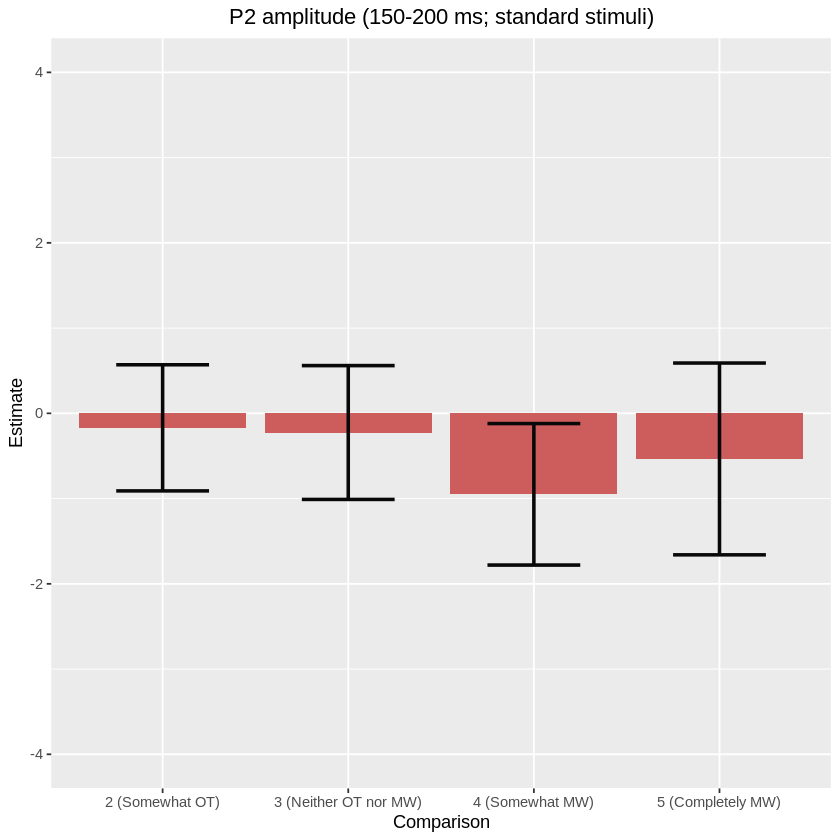

In [56]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='indianred' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-4,4) + 
        ggtitle("P2 amplitude (150-200 ms; standard stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison")

ggsave(filename='standard-p2.png', dpi=600)

### Compare MW1 oddball instead

In [44]:
# relevel data to focus on standard and MW1

dat[,'MentalState'] <- relevel(dat[,'MentalState'],'MW1')
dat[,'StimType'] <- relevel(dat[,'StimType'],'Oddball')

cl <- makeCluster(num_cores)

m7r <- bam(meanAmpl ~ StimType * MentalState  
           + s(Subj, bs="re") 
           + s(StimTypebySubj, bs="re") 
           + s(MentalStatebySubj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [61]:
mod = m7r

mod_summary = anova(mod)
capture.output(mod_summary, file=paste(outdir, 'ANOVA_table ', CurTimeWin, 
                                       '.txt' ,sep=''))

mod_summary


Family: gaussian 
Link function: identity 

Formula:
meanAmpl ~ StimType * MentalState + s(Subj, bs = "re") + s(StimTypebySubj, 
    bs = "re") + s(MentalStatebySubj, bs = "re")

Parametric Terms:
                     df    F p-value
StimType              1 1.77  0.1839
MentalState           4 2.49  0.0409
StimType:MentalState  4 3.94  0.0034

Approximate significance of smooth terms:
                        edf Ref.df    F p-value
s(Subj)                9.47  47.00 21.2 0.14679
s(StimTypebySubj)     61.48  94.00 32.7 0.00239
s(MentalStatebySubj) 114.05 173.00 14.9 0.00025

In [62]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
meanAmpl ~ StimType * MentalState + s(Subj, bs = "re") + s(StimTypebySubj, 
    bs = "re") + s(MentalStatebySubj, bs = "re")

Parametric coefficients:
                                Estimate Std. Error t value Pr(>|t|)   
(Intercept)                        0.234      0.357    0.66   0.5112   
StimTypeStandard                   0.453      0.341    1.33   0.1839   
MentalStateMW2                    -0.282      0.387   -0.73   0.4666   
MentalStateMW3                    -1.135      0.418   -2.71   0.0067 **
MentalStateMW4                    -0.642      0.446   -1.44   0.1500   
MentalStateMW5                    -1.230      0.636   -1.93   0.0531 . 
StimTypeStandard:MentalStateMW2    0.113      0.302    0.37   0.7090   
StimTypeStandard:MentalStateMW3    0.908      0.342    2.66   0.0079 **
StimTypeStandard:MentalStateMW4   -0.311      0.370   -0.84   0.4004   
StimTypeStandard:MentalStateMW5    0.699      0.547    1.28   0.2018   
---

### Visualize the results

In [63]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Neither OT nor MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),-0.28,0.387,0.69,-1.25,-0.73,0.46658,0.4666
3 (Neither OT nor MW),-1.14,0.418,-0.09,-2.18,-2.71,0.00666,0.0266
4 (Somewhat MW),-0.64,0.446,0.47,-1.76,-1.44,0.15002,0.3000
5 (Completely MW),-1.23,0.636,0.36,-2.82,-1.93,0.05313,0.1594


Saving 6.67 x 6.67 in image


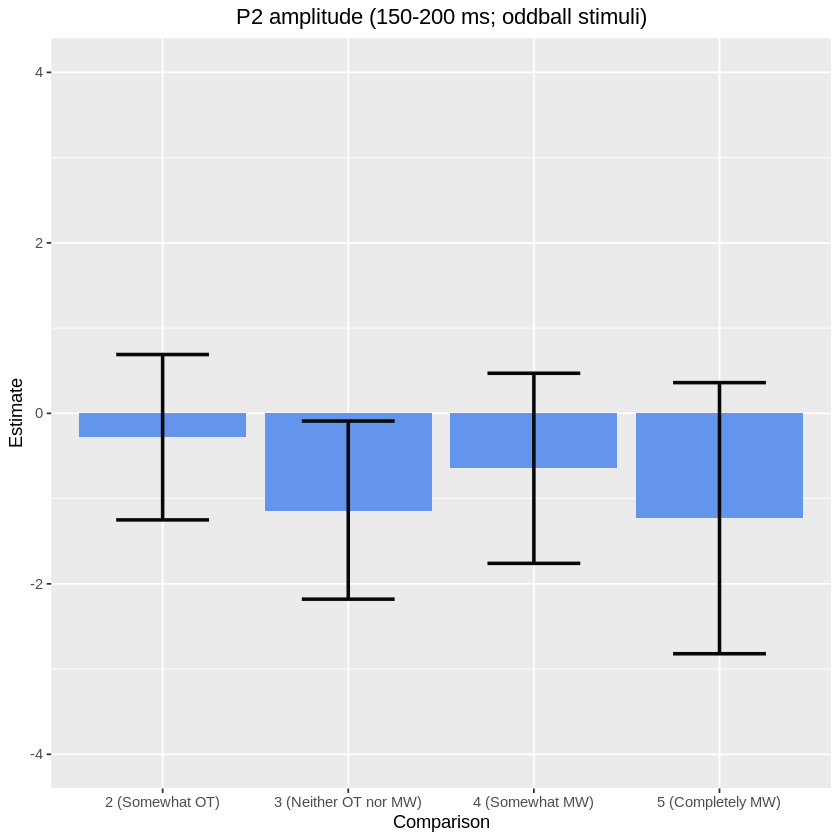

In [64]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='cornflowerblue' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-4,4) + 
        ggtitle("P2 amplitude (150-200 ms; oddball stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison")

ggsave(filename='oddball-p2.png', dpi=600)